Code to test that simple_pe metric does what we want

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from pycbc import conversions, psd
from pycbc.filter import match

from simple_pe.param_est import metric
from pesummary.utils.samples_dict import SamplesDict

In [2]:
ifos = ['H1', 'L1', 'V1']

psds = {'H1': 'aLIGOMidHighSensitivityP1200087',
        'L1': 'aLIGOMidHighSensitivityP1200087',
        'V1': 'AdVMidHighSensitivityP1200087',
        'f_low': 20.,
        'f_high': 8192,
        'length': 32
        }

psds['delta_f'] = 1. / psds['length']

In [3]:
pycbc_psd = {}
for ifo in ifos:
    pycbc_psd[ifo] = psd.analytical.from_string(psds[ifo], psds['length'] * psds['f_high'] + 1, psds['delta_f'],
                                                psds['f_low'])

pycbc_psd['harm'] = 3. / sum([1. / pycbc_psd[ifo] for ifo in ifos])

/home/spxsf2/miniconda3/envs/igwn-py38/lib/python3.8/site-packages/pycbc/types/array.py:375: RuntimeWarning: divide by zero encountered in true_divide
  return self._data.__rtruediv__(other)


In [4]:
m1 = 30.
m2 = 10.
mc = conversions.mchirp_from_mass1_mass2(m1, m2)
eta = conversions.eta_from_mass1_mass2(m1, m2)
s1z = 0.3
s2z = 0.
chi_eff = conversions.chi_eff(m1, m2, s1z, s2z)
dist = 1.

In [5]:
params = {'chirp_mass': mc,
          'symmetric_mass_ratio': eta,
          'chi_eff':chi_eff,
        }

In [6]:
params = {'chirp_mass':15.288, 
          'symmetric_mass_ratio':0.180,
          'chi_eff':0.232
         }

In [7]:
dx = {'chirp_mass':0.5, 
          'symmetric_mass_ratio':0.02,
          'chi_eff':0.02
         }

Make original and varied waveform

In [8]:
h = metric.make_waveform(params, dx, 0, dist, psds['delta_f'], psds['f_low'], len(pycbc_psd['harm']))
h_prime = metric.make_waveform(params, dx, 1, dist, psds['delta_f'], psds['f_low'], len(pycbc_psd['harm']))

2022-06-16  15:30:56 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:30:56 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:30:56 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:30:56 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:30:56 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:30:56 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:30:56 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the c

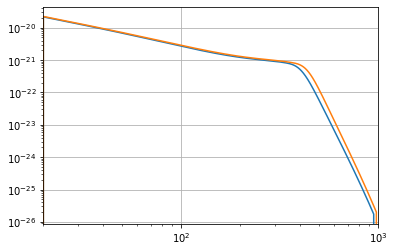

In [9]:
plt.loglog(h.sample_frequencies, abs(h))
plt.loglog(h_prime.sample_frequencies, abs(h_prime))
plt.xlim(20,1000)
plt.grid()

Check that the parameters are physical

In [10]:
scales = np.linspace(-10,10,21)
alphas = np.zeros_like(scales)
for i,s in enumerate(scales):
    alphas[i] = metric.check_physical(params, dx, scaling=s)

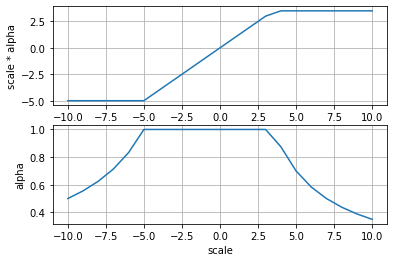

In [11]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(scales, scales*alphas)
ax1.set(ylabel='scale * alpha')
ax1.grid()

ax2.plot(scales, alphas)
ax2.set(xlabel='scale', ylabel='alpha')
ax2.grid()

In [12]:
for k,i in dx.items():
    print('%s at lower limit: %.2f' % (k, params[k] + i * (alphas[0] * scales[0])))
    print('%s at upper limit: %.2f' % (k, params[k] + i * (alphas[-1] * scales[-1])))

chirp_mass at lower limit: 12.79
chirp_mass at upper limit: 17.04
symmetric_mass_ratio at lower limit: 0.08
symmetric_mass_ratio at upper limit: 0.25
chi_eff at lower limit: 0.13
chi_eff at upper limit: 0.30


Check average mismatch

In [13]:
dist=1.
scaling=1.

In [14]:
metric.average_mismatch(params, dx, scaling, dist, psds['f_low'], pycbc_psd['harm'], verbose=True)

2022-06-16  15:30:58 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:30:58 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:30:58 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:30:58 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:30:58 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:30:58 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:30:58 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the c

Had to scale steps to 1.00, 1.00
Mismatches 0.077, 0.086


0.08159509273483345

Check scaling of vector to desired mismatch

In [15]:
desired_mismatch = 0.03

In [16]:
scale = metric.scale_dx(params, dx, desired_mismatch, dist, psds['f_low'], pycbc_psd['harm'])

2022-06-16  15:30:58 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:30:58 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:30:58 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:30:58 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:30:58 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:30:58 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:30:58 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the c

2022-06-16  15:30:59 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:30:59 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:30:59 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:30:59 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:30:59 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:30:59 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:30:59 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022

2022-06-16  15:30:59 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:30:59 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:30:59 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:30:59 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:30:59 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default


Check this is right

In [17]:
ave_mis = metric.average_mismatch(params, dx, scale, dist, psds['f_low'], pycbc_psd['harm'], verbose=True)
print("desired mismatch = %.3g, average mismatch returned = %.3g" % (desired_mismatch, ave_mis))

2022-06-16  15:30:59 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:30:59 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:30:59 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:30:59 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:30:59 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:30:59 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:30:59 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the c

Had to scale steps to 1.00, 1.00
Mismatches 0.029, 0.031
desired mismatch = 0.03, average mismatch returned = 0.03


Calculate the metric

In [18]:
desired_mismatch = 0.009

In [19]:
dx_directions = ['chirp_mass', 'symmetric_mass_ratio', 'chi_eff']
ndim = len(dx_directions)
v0 = np.eye(ndim)
dx0 = SamplesDict(dx_directions, v0)

In [20]:
print(dx0)

idx     chirp_mass     symmetric_mass_ratiochi_eff        
0       1.000000       0.000000       0.000000       
1       0.000000       1.000000       0.000000       
2       0.000000       0.000000       1.000000       



Let's first scale these to the desired mismatch

In [21]:
dxs = metric.scale_dx_array(params, dx0, desired_mismatch, dist, psds['f_low'], pycbc_psd['harm'])

2022-06-16  15:30:59 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:30:59 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:30:59 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:30:59 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:30:59 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:30:59 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:30:59 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the c

2022-06-16  15:31:00 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:31:00 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:31:00 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:31:00 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:31:00 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:31:00 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:31:00 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022

2022-06-16  15:31:01 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:31:01 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:31:01 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:31:01 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:31:01 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:31:01 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:31:01 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-

2022-06-16  15:31:01 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:31:01 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:31:01 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:31:01 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:31:01 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:31:01 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:31:01 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default


2022-06-16  15:31:02 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:31:02 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:31:02 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:31:02 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:31:02 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:31:02 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:31:02 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-

2022-06-16  15:31:02 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:31:02 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:31:02 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:31:02 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:31:02 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:31:02 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:31:02 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default


2022-06-16  15:31:03 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:31:03 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:31:03 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:31:03 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:31:03 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:31:03 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:31:03 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-

2022-06-16  15:31:03 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:31:03 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:31:03 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:31:03 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:31:03 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:31:03 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:31:03 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default


2022-06-16  15:31:04 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:31:04 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:31:04 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:31:04 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:31:04 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:31:04 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:31:04 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-

In [22]:
print(dxs)

idx     chirp_mass     symmetric_mass_ratiochi_eff        
0       0.051334       0.000000       0.000000       
1       0.000000       0.003955       0.000000       
2       0.000000       0.000000       0.012931       



And verify

In [23]:
mis = np.zeros(ndim)
for i in range(ndim):
    dx = dxs[i:i+1]
    mis[i] = metric.average_mismatch(params, dx, scaling, dist, psds['f_low'], pycbc_psd['harm'])

2022-06-16  15:31:04 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:31:04 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:31:04 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:31:04 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:31:04 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:31:04 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:31:04 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the c

In [24]:
print(mis)

[0.00898897 0.00897987 0.00900439]


See what the "diagonal" variations are

In [25]:
mis_plus = np.zeros([3,3])
mis_minus = np.zeros([3,3])
for i in range(3):
    for j in range(3):
        dx = SamplesDict(dx_directions, 1./np.sqrt(2) * (dxs.samples[i] + dxs.samples[j]))
        mis_plus[i,j] = metric.average_mismatch(params, dx, scaling, dist, psds['f_low'], pycbc_psd['harm'])
        dx = SamplesDict(dx_directions, 1./np.sqrt(2) * (dxs.samples[i] - dxs.samples[j]))
        mis_minus[i,j] = metric.average_mismatch(params, dx, scaling, dist, psds['f_low'], pycbc_psd['harm'])

2022-06-16  15:31:05 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:31:05 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:31:05 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:31:05 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:31:05 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:31:05 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:31:05 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the c

2022-06-16  15:31:06 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:31:06 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:31:06 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:31:06 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:31:06 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:31:06 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:31:06 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022

2022-06-16  15:31:06 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:31:06 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:31:06 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:31:06 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:31:06 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:31:06 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:31:06 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-

2022-06-16  15:31:07 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:31:07 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:31:07 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:31:07 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:31:07 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:31:07 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:31:07 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default


2022-06-16  15:31:08 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:31:08 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:31:08 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:31:08 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:31:08 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:31:08 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:31:08 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-

In [26]:
desired_mismatch

0.009

In [27]:
mis_plus, mis_minus

(array([[0.01759708, 0.00036174, 0.0002496 ],
        [0.00036174, 0.01786352, 0.01787549],
        [0.0002496 , 0.01787549, 0.01787787]]),
 array([[0.00000000e+00, 1.74946928e-02, 1.75121592e-02],
        [1.74946928e-02, 0.00000000e+00, 9.68406565e-05],
        [1.75121592e-02, 9.68406565e-05, 0.00000000e+00]]))

So, if I step in the mc+eta, mc+chi_eff, eta-chi_eff directions then the match falls off slowly -- these are the directions of degeneracies

Calculate the metric

In [28]:
gij = metric.calculate_metric(params, dxs, dist, psds['f_low'], pycbc_psd['harm'])

2022-06-16  15:31:08 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:31:08 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:31:08 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:31:08 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:31:08 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:31:08 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:31:08 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the c

2022-06-16  15:31:09 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:31:09 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:31:09 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:31:09 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:31:09 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:31:09 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:31:09 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022

2022-06-16  15:31:09 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:31:09 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:31:09 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:31:09 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:31:09 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:31:09 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:31:09 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-

In [29]:
print(gij)

[[   3.41119203   42.19770882   13.00300208]
 [  42.19770882  574.17871561 -173.83119782]
 [  13.00300208 -173.83119782   53.85116471]]


Metric should return desired mismatch for diagonal components:

In [30]:
mismatches = np.inner(np.inner(dxs.samples, gij), dxs.samples)
print(mismatches)

[[ 0.00898897  0.00856648  0.00863128]
 [ 0.00856648  0.00897987 -0.00888933]
 [ 0.00863128 -0.00888933  0.00900439]]


In [61]:
np.inner(dxs.samples, evals*evecs)

array([[ 0.07634954,  0.22964751,  0.19333244],
       [ 0.22964751,  2.62826346, -0.7857254 ],
       [ 0.19333244, -0.7857254 ,  0.30611129]])

We're looking for a basis in which the metric is diagonal.  Won't be there yet, but check anyway

In [31]:
error = metric.metric_error(gij, dxs, desired_mismatch)
print(error)

0.00888932530050657


But at least the diagonals should give the right mismatch

In [32]:
diag = np.eye(ndim)
np.fill_diagonal(diag, gij.diagonal())
diag_error = metric.metric_error(diag, dxs, desired_mismatch)
print(diag_error)

4.394291927342989e-06


In [62]:
g = np.inner(np.inner(dxs.samples, gij), dxs.samples)

In [69]:
evals, evec = np.linalg.eig(g)
evals[evals <= 0] = 1

In [70]:
v = (evec * np.sqrt(desired_mismatch / evals))

In [71]:
evals

array([0.04400322, 0.00141336, 1.        ])

In [76]:
np.inner(np.linalg.inv(dx0.samples), v)

array([[-0.51246306,  1.13774083, -2.06488392],
       [ 0.41832841, -0.39202198,  0.39323009],
       [-0.2267313 , -0.2154159 ,  0.42354083]])

What are the eigendirections of our initial metric?

In [33]:
evals, evecs = np.linalg.eig(gij)

In [34]:
evals, evecs

(array([629.05381028, -23.45648003,  25.8437421 ]),
 array([[-0.0585003 , -0.70490597,  0.70688421],
        [-0.9559685 ,  0.24354032,  0.16374475],
        [ 0.28757947,  0.66617991,  0.68811509]]))

In [48]:
dx0 = SamplesDict(dx_directions, evecs)

In [50]:
dxs = metric.scale_dx_array(params, dx0, desired_mismatch, dist, psds['f_low'], pycbc_psd['harm'])

2022-06-16  15:35:16 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:35:16 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:35:16 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:35:16 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:35:16 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:35:16 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:35:16 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the c

2022-06-16  15:35:17 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:35:17 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:35:17 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:35:17 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:35:17 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:35:17 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:35:17 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022

2022-06-16  15:35:17 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:35:17 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:35:17 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:35:17 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:35:17 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:35:17 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:35:17 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-

2022-06-16  15:35:18 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:35:18 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:35:18 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:35:18 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:35:18 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:35:18 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:35:18 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default


2022-06-16  15:35:18 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:35:18 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:35:18 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:35:18 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:35:18 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:35:18 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:35:18 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-

2022-06-16  15:35:19 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:35:19 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:35:19 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:35:19 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:35:19 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:35:19 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:35:19 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default


2022-06-16  15:35:19 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:35:19 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:35:19 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:35:19 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:35:19 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:35:19 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:35:19 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-

2022-06-16  15:35:19 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:35:19 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:35:19 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:35:19 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:35:19 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:35:19 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:35:19 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default


2022-06-16  15:35:20 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:35:20 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:35:20 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:35:20 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:35:20 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:35:20 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:35:20 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-

2022-06-16  15:35:20 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:35:20 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:35:20 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:35:20 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:35:20 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:35:20 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:35:20 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default


In [51]:
dxs

{'chirp_mass': Array([-0.00026771, -0.00558069,  0.00869103]),
 'symmetric_mass_ratio': Array([-0.00437471,  0.00192809,  0.00201322]),
 'chi_eff': Array([0.00131602, 0.0052741 , 0.00846027])}

Now update the metric based on the eigendirections of the existing metric

In [42]:
gij_prime, dxs_prime = metric.update_metric(params, gij, dxs.keys(), desired_mismatch, dist, psds['f_low'], pycbc_psd['harm'])

2022-06-16  15:32:27 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:27 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:27 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:27 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:27 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:27 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:27 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the c

2022-06-16  15:32:28 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:28 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:28 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:28 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:28 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:28 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:28 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022

2022-06-16  15:32:29 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:29 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:29 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:29 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:29 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:29 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:29 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-

2022-06-16  15:32:29 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:29 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:29 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:29 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:29 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:29 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:29 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default


2022-06-16  15:32:30 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:30 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:30 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:30 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:30 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:30 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:30 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-

2022-06-16  15:32:31 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:31 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:31 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:31 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:31 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:31 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:31 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default


2022-06-16  15:32:31 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:31 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:31 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:31 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:32 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:32 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:32 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-

2022-06-16  15:32:32 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:32 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:32 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:32 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:32 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:32 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:32 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default


2022-06-16  15:32:33 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:33 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:33 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:33 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:33 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:33 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:33 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-

2022-06-16  15:32:33 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:33 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:33 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:33 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:33 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:33 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:33 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default


2022-06-16  15:32:34 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:34 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:34 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:34 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:34 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:34 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:34 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-

In [43]:
print(gij_prime)

[[697.58271266 242.4456847   14.00760102]
 [242.4456847  -84.87966999 -21.41942647]
 [ 14.00760102 -21.41942647 117.22862892]]


In [44]:
print(dxs_prime)

idx     chirp_mass     symmetric_mass_ratiochi_eff        
0       -0.000268      -0.004375      0.001316       
1       -0.005584      0.001929       0.005277       
2       0.008691       0.002013       0.008460       



In [45]:
mismatches = np.inner(np.inner(dxs_prime.samples, gij_prime), dxs_prime.samples)
print(mismatches)

[[ 0.00899677  0.00892199  0.0089088 ]
 [ 0.00892199  0.00900555 -0.00892482]
 [ 0.0089088  -0.00892482  0.0090023 ]]


In [46]:
error = metric.metric_error(gij_prime, dxs_prime, desired_mismatch)
print(error)

0.008924822685307143


And iteratively update

In [47]:
gij, dxs, tol = metric.iteratively_update_metric(params, gij, params.keys(), desired_mismatch, dist,
                              psds['f_low'], pycbc_psd['harm'],
                              max_iter=20, verbose=True)

2022-06-16  15:32:35 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:35 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:35 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:35 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:35 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:35 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:35 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the c

Initial error in metric: 2.6e+04


2022-06-16  15:32:36 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:36 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:36 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:36 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:36 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:36 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:36 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the c

2022-06-16  15:32:36 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:36 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:36 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:36 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:36 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:36 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:36 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022

2022-06-16  15:32:36 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:36 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:36 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:36 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:36 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:36 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:36 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-

2022-06-16  15:32:37 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:37 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:37 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:37 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:37 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:37 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:37 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default


2022-06-16  15:32:37 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:37 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:37 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:37 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:37 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:37 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:37 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-

2022-06-16  15:32:38 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:38 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:38 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:38 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:38 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:38 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:38 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default


2022-06-16  15:32:38 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:38 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:38 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:38 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:38 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:38 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:38 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-

2022-06-16  15:32:39 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:39 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:39 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:39 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:39 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:39 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:39 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default


2022-06-16  15:32:39 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:39 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:39 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:39 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:39 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:39 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:39 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-

2022-06-16  15:32:40 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:40 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:40 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:40 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:40 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:40 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:40 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default


2022-06-16  15:32:40 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:40 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:40 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:40 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:40 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:40 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:40 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-

Iteration 1, desired error=9e-05, max error=0.0089
[[697.58271266 242.4456847   14.00760102]
 [242.4456847  -84.87966999 -21.41942647]
 [ 14.00760102 -21.41942647 117.22862892]]


2022-06-16  15:32:40 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:40 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:40 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:40 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:40 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:40 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:40 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the c

2022-06-16  15:32:41 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:41 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:41 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:41 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:41 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:41 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:41 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022

2022-06-16  15:32:41 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:41 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:41 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:41 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:41 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:41 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:41 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-

2022-06-16  15:32:42 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:42 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:42 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:42 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:42 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:42 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:42 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default


2022-06-16  15:32:42 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:42 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:42 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:42 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:42 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:42 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:42 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-

2022-06-16  15:32:43 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:43 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:43 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:43 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:43 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:43 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:43 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default


2022-06-16  15:32:43 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:43 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:43 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:43 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:43 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:43 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:43 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-

2022-06-16  15:32:43 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:43 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:43 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:44 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:44 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:44 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:44 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default


2022-06-16  15:32:44 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:44 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:44 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:44 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:44 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:44 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:44 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-

2022-06-16  15:32:44 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:44 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:44 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:44 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:44 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:44 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:44 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default


2022-06-16  15:32:45 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:45 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:45 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:45 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:45 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:45 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:45 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-

2022-06-16  15:32:45 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:45 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:45 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default


Iteration 2, desired error=9e-05, max error=0.0089
[[  36.94471065  -94.51700883  -19.26052022]
 [ -94.51700883  404.6374739  -153.86219023]
 [ -19.26052022 -153.86219023   21.25170222]]


2022-06-16  15:32:45 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:45 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:45 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:45 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:46 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:46 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:46 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the c

2022-06-16  15:32:46 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:46 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:46 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:46 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:46 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:46 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:46 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022

2022-06-16  15:32:46 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:47 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:47 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:47 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:47 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:47 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:47 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-

2022-06-16  15:32:47 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:47 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:47 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:47 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:47 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:47 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:47 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default


2022-06-16  15:32:47 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:47 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:47 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:47 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:47 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:48 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:48 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-

2022-06-16  15:32:48 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:48 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:48 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:48 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:48 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:48 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:48 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default


2022-06-16  15:32:48 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:48 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:48 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:48 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:48 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:48 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:48 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-

2022-06-16  15:32:49 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:49 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:49 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:49 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:49 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:49 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:49 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default


2022-06-16  15:32:49 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:49 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:49 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:49 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:49 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:49 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:49 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-

2022-06-16  15:32:50 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:50 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:50 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:50 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:50 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:50 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:50 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default


2022-06-16  15:32:50 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:50 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:50 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:50 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:50 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:50 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:50 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-

2022-06-16  15:32:51 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:51 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:51 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default


Iteration 3, desired error=9e-05, max error=0.0089
[[-10.42410286  51.53831457 360.68898561]
 [ 51.53831457  59.61033937 -22.20126552]
 [360.68898561 -22.20126552 208.88314966]]


2022-06-16  15:32:51 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:51 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:51 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:51 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:51 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:51 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:51 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the c

2022-06-16  15:32:51 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:51 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:51 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:51 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:51 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:51 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:51 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022

2022-06-16  15:32:52 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:52 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:52 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:52 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:52 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:52 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:52 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-

2022-06-16  15:32:52 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:52 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:52 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:52 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:52 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:52 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:52 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default


2022-06-16  15:32:53 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:53 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:53 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:53 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:53 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:53 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:53 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-

2022-06-16  15:32:53 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:53 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:53 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:53 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:53 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:53 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:53 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default


2022-06-16  15:32:54 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:54 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:54 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:54 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:54 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:54 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:54 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-

2022-06-16  15:32:54 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:54 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:54 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:54 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:54 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:54 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:54 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default


2022-06-16  15:32:55 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:55 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:55 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:55 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:55 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:55 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:55 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-

2022-06-16  15:32:55 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:55 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:55 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:55 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:55 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:55 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:55 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default


2022-06-16  15:32:56 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:56 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:56 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:56 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:56 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:56 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:56 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-

2022-06-16  15:32:56 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:56 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:56 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default


Iteration 4, desired error=9e-05, max error=0.0089
[[  60.12789751   18.97677876   22.55908214]
 [  18.97677876  -30.78956421 -247.92525765]
 [  22.55908214 -247.92525765  723.87242729]]


2022-06-16  15:32:56 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:56 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:56 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:56 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:56 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:56 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:56 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the c

2022-06-16  15:32:57 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:57 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:57 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:57 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:57 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:57 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:57 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022

2022-06-16  15:32:57 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:57 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:57 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:57 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:57 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:57 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:57 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-

2022-06-16  15:32:58 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:58 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:58 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:58 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:58 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:58 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:58 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default


2022-06-16  15:32:58 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:58 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:58 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:58 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:58 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:58 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:58 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-

2022-06-16  15:32:59 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:59 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:59 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:59 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:59 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:59 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:59 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default


2022-06-16  15:32:59 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:59 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:59 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-16  15:32:59 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default
2022-06-16  15:32:59 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2022-06-16  15:32:59 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2022-06-16  15:32:59 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2022-06-

ValueError: f(a) and f(b) must have different signs